<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/main/13-GANs/GAN_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Modify snippets below and implement [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with weight clipping. (2 points)

* Replace  weight clipping with [gradient penalty](https://arxiv.org/pdf/1704.00028v3.pdf). (2 points)

* Add labels into WGAN, performing [conditional generation](https://arxiv.org/pdf/1411.1784.pdf). (2 points)

Write a report about experiments and results, add plots and visualizations.

### Creating config object (argparse workaround)

ERROR: Ignored the following yanked versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3
ERROR: Could not find a version that satisfies the requirement torchvision==0.15.2 (from versions: 0.17.0, 0.17.1, 0.17.2, 0.18.0, 0.18.1, 0.19.0, 0.19.1, 0.20.0, 0.20.1, 0.21.0, 0.22.0, 0.22.1, 0.23.0, 0.24.0, 0.24.1)
ERROR: No matching distribution found for torchvision==0.15.2
Running WGAN (weight clipping)...


Epoch 1/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6/6:   0%|          | 0/937 [00:00<?, ?it/s]

Running WGAN-GP (unconditional)...


Epoch 1/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6/6:   0%|          | 0/937 [00:00<?, ?it/s]

Running Conditional WGAN-GP...


Epoch 1/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 2/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 3/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 4/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 5/6:   0%|          | 0/937 [00:00<?, ?it/s]

Epoch 6/6:   0%|          | 0/937 [00:00<?, ?it/s]

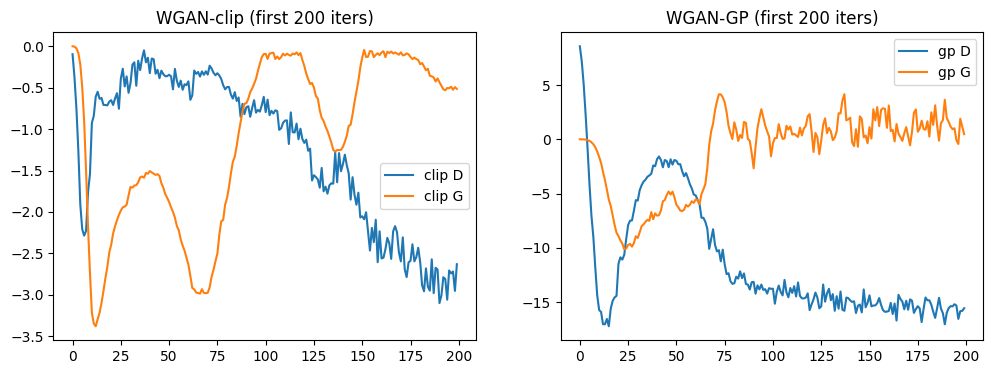

Saved sample images: ['wgan_outputs/clip_epoch_1.png', 'wgan_outputs/clip_epoch_2.png', 'wgan_outputs/clip_epoch_3.png', 'wgan_outputs/clip_epoch_4.png', 'wgan_outputs/clip_epoch_5.png', 'wgan_outputs/clip_epoch_6.png']


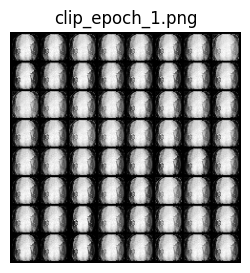

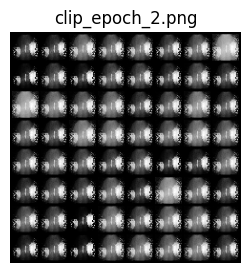

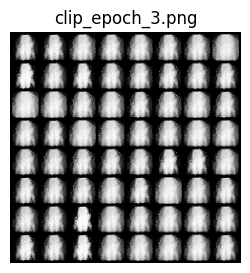

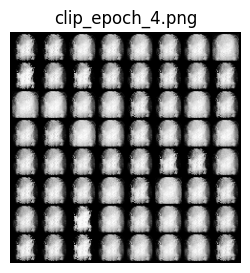

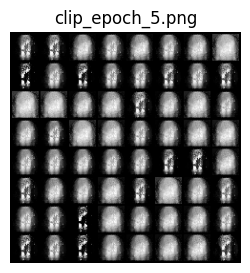

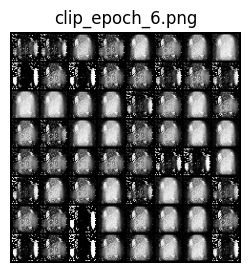

In [2]:
!pip install -q torchvision==0.15.2 torch==2.0.1 tqdm
import os
import math
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, utils
from torch.autograd import grad
from tqdm.notebook import tqdm

class Config: pass
config = Config()
config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config.batch_size = 64
config.num_workers = 2
config.num_epochs = 6
config.noise_size = 100
config.print_freq = 200
config.save_dir = "wgan_outputs"
os.makedirs(config.save_dir, exist_ok=True)
config.lr = 1e-4
config.beta1 = 0.0
config.beta2 = 0.9
config.image_size = 28
config.nc = 1
config.n_critic = 5
config.lambda_gp = 10.0
config.clip_value = 0.01
config.seed = 42
random.seed(config.seed); np.random.seed(config.seed); torch.manual_seed(config.seed)

transform = transforms.Compose([transforms.ToTensor()])
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=transform, download=True)
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True, num_workers=config.num_workers, drop_last=True)

def save_image_grid(tensor_imgs, path, nrow=8):
    grid = utils.make_grid(tensor_imgs.cpu(), nrow=nrow, normalize=True, scale_each=True)
    utils.save_image(grid, path)

def show_grid_from_tensor(t):
    grid = utils.make_grid(t, nrow=8, normalize=True, scale_each=True)
    plt.figure(figsize=(6,6)); plt.axis('off'); plt.imshow(grid.permute(1,2,0).cpu()); plt.show()

def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.Linear)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if getattr(m, "bias", None) is not None:
            nn.init.constant_(m.bias.data, 0.0)

class Generator(nn.Module):
    def __init__(self, noise_dim=100, out_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, out_channels*28*28),
            nn.Tanh()
        )
    def forward(self, z):
        x = self.net(z)
        x = x.view(-1, config.nc, config.image_size, config.image_size)
        return x

class Critic(nn.Module):
    def __init__(self, in_channels=1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels*28*28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        return self.net(x).view(-1)

class CondGenerator(nn.Module):
    def __init__(self, noise_dim=100, n_classes=10, out_channels=1, emb_dim=50):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, emb_dim)
        self.net = nn.Sequential(
            nn.Linear(noise_dim + emb_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, out_channels*28*28),
            nn.Tanh()
        )
    def forward(self, z, labels):
        le = self.label_emb(labels)
        inp = torch.cat([z, le], dim=1)
        x = self.net(inp)
        x = x.view(-1, config.nc, config.image_size, config.image_size)
        return x

class CondCritic(nn.Module):
    def __init__(self, n_classes=10, emb_dim=50, in_channels=1):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, emb_dim)
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_channels*28*28 + emb_dim, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1)
        )
    def forward(self, x, labels):
        le = self.label_emb(labels)
        xflat = x.view(x.size(0), -1)
        inp = torch.cat([xflat, le], dim=1)
        return self.net(inp).view(-1)

def gradient_penalty(critic, real, fake, device, labels=None):
    batch_size = real.size(0)
    epsilon = torch.rand(batch_size, 1, 1, 1, device=device)
    epsilon = epsilon.expand_as(real)
    interp = (epsilon * real + (1 - epsilon) * fake).requires_grad_(True)
    if labels is None:
        out = critic(interp)
    else:
        out = critic(interp, labels)
    grads = grad(outputs=out, inputs=interp,
                 grad_outputs=torch.ones_like(out),
                 create_graph=True, retain_graph=True, only_inputs=True)[0]
    grads = grads.view(batch_size, -1)
    gp = ((grads.norm(2, dim=1) - 1) ** 2).mean()
    return gp

def train_wgan(weight_clip=True, use_gp=False, conditional=False):
    device = config.device
    if conditional:
        G = CondGenerator(noise_dim=config.noise_size, n_classes=10).to(device)
        D = CondCritic(n_classes=10).to(device)
    else:
        G = Generator(noise_dim=config.noise_size).to(device)
        D = Critic().to(device)
    G.apply(weights_init); D.apply(weights_init)
    optim_G = optim.RMSprop(G.parameters(), lr=5e-5) if weight_clip else optim.Adam(G.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))
    optim_D = optim.RMSprop(D.parameters(), lr=5e-5) if weight_clip else optim.Adam(D.parameters(), lr=config.lr, betas=(config.beta1, config.beta2))

    fixed_z = torch.randn(64, config.noise_size, device=device)
    fixed_labels = torch.arange(0,10).repeat(7)[:64].to(device) if conditional else None

    history = {"d_loss":[], "g_loss":[]}
    it = 0
    for epoch in range(config.num_epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{config.num_epochs}")
        for real_imgs, labels in pbar:
            real_imgs = real_imgs.to(device) * 2 - 1
            bsz = real_imgs.size(0)
            for _ in range(config.n_critic):
                z = torch.randn(bsz, config.noise_size, device=device)
                if conditional:
                    fake_imgs = G(z, labels.to(device))
                    D_real = D(real_imgs, labels.to(device))
                    D_fake = D(fake_imgs.detach(), labels.to(device))
                else:
                    fake_imgs = G(z)
                    D_real = D(real_imgs)
                    D_fake = D(fake_imgs.detach())
                loss_D = -(torch.mean(D_real) - torch.mean(D_fake))
                if use_gp:
                    gp = gradient_penalty(D, real_imgs, fake_imgs, device, labels.to(device) if conditional else None)
                    loss_D = loss_D + config.lambda_gp * gp
                optim_D.zero_grad()
                loss_D.backward()
                optim_D.step()
                if weight_clip and not use_gp:
                    for p in D.parameters():
                        p.data.clamp_(-config.clip_value, config.clip_value)
            z = torch.randn(bsz, config.noise_size, device=device)
            if conditional:
                fake_imgs = G(z, labels.to(device))
                D_fake_for_g = D(fake_imgs, labels.to(device))
            else:
                fake_imgs = G(z)
                D_fake_for_g = D(fake_imgs)
            loss_G = -torch.mean(D_fake_for_g)
            optim_G.zero_grad()
            loss_G.backward()
            optim_G.step()

            history["d_loss"].append(loss_D.item())
            history["g_loss"].append(loss_G.item())
            it += 1

            if it % config.print_freq == 0:
                pbar.set_postfix({"d_loss": loss_D.item(), "g_loss": loss_G.item()})

        with torch.no_grad():
            if conditional:
                fake = G(fixed_z, fixed_labels)
            else:
                fake = G(fixed_z)
            save_image_grid((fake + 1) / 2.0, os.path.join(config.save_dir, f"{'cond_' if conditional else ''}{'gp_' if use_gp else 'clip_'}epoch_{epoch+1}.png"))
    return G, D, history

print("Running WGAN (weight clipping)...")
G_clip, D_clip, h_clip = train_wgan(weight_clip=True, use_gp=False, conditional=False)

print("Running WGAN-GP (unconditional)...")
G_gp, D_gp, h_gp = train_wgan(weight_clip=False, use_gp=True, conditional=False)

print("Running Conditional WGAN-GP...")
G_cgp, D_cgp, h_cgp = train_wgan(weight_clip=False, use_gp=True, conditional=True)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(h_clip["d_loss"][:200], label="clip D")
plt.plot(h_clip["g_loss"][:200], label="clip G")
plt.legend(); plt.title("WGAN-clip (first 200 iters)")
plt.subplot(1,2,2)
plt.plot(h_gp["d_loss"][:200], label="gp D")
plt.plot(h_gp["g_loss"][:200], label="gp G")
plt.legend(); plt.title("WGAN-GP (first 200 iters)")
plt.show()

from glob import glob
imgs = sorted(glob(os.path.join(config.save_dir, "*.png")))
print("Saved sample images:", imgs[:6])
for i, p in enumerate(imgs[:6]):
    img = plt.imread(p)
    plt.figure(figsize=(3,3)); plt.axis('off'); plt.imshow(img); plt.title(os.path.basename(p))
